In [2]:
import sys
print(sys.executable)
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
from time import time
import pandas as pd
from glob import glob
from KerasOCRTrainer2 import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import cv2
from PIL import Image
from random import shuffle

/home/eduard/.pyenv/versions/3.6.8/envs/keras_gpu_36/bin/python3.6


In [3]:
# tf.test.is_gpu_available()

# Create df to flow from

In [4]:
# ubuntu
file_list_2 = glob('/home/eduard/workspace/VitmoOCR/data/data2/*/*.png')
# shuffle(file_list_2)
file_list_4 = glob('/home/eduard/workspace/VitmoOCR/data/data4/*/*.png')
# shuffle(file_list_4)
file_list_5 = glob('/home/eduard/workspace/VitmoOCR/data/data5/*/*.png')
# shuffle(file_list_5)
file_list_6 = glob('/home/eduard/workspace/VitmoOCR/data/data6/*/*.png')
# shuffle(file_list_6)
file_list_7 = glob('/home/eduard/workspace/VitmoOCR/data/data7/*/*.png')
# shuffle(file_list_7)
file_list_t = glob('/home/eduard/workspace/VitmoOCR/data/training_data/*/*.jpg')
# shuffle(file_list_t)

file_list = file_list_2+file_list_4+file_list_5+file_list_6+file_list_7
shuffle(file_list)
# mac
# file_list = glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/data2/*/*.png')
# file_list = file_list+glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/training_data/numbers_96/*/*.jpg')
df_lst = []
for file_path in file_list:
    label = file_path.split('/')[-2]
    alt_label = label
    while len(alt_label)<3:
        alt_label = ' '+alt_label
    if alt_label == 'nan':
        alt_label = '   '
        
    l0,l1,l2 = alt_label
    
    df_lst.append({
        'file_path': file_path,
        'single_label':label,
        'multi_label':np.array([l0,l1,l2]),
        'l0':str(l0),
        'l1':str(l1),
        'l2':str(l2),
#         'splitable':f'{l0},{l1},{l2}'
    }
    )
df = pd.DataFrame(df_lst)
print(df.shape)

(708004, 6)


In [5]:
df.head()

,file_path,single_label,multi_label,l0,l1,l2
0,/home/eduard/workspace/VitmoOCR/data/data6/104...,104,"[1, 0, 4]",1,0,4
1,/home/eduard/workspace/VitmoOCR/data/data6/19/...,19,"[ , 1, 9]",,1,9
2,/home/eduard/workspace/VitmoOCR/data/data6/39/...,39,"[ , 3, 9]",,3,9
3,/home/eduard/workspace/VitmoOCR/data/data4/84/...,84,"[ , 8, 4]",,8,4
4,/home/eduard/workspace/VitmoOCR/data/data7/164...,164,"[1, 6, 4]",1,6,4


In [6]:
def one_hot(cat):
    categories = [' ','0','1','2','3','4','5','6','7','8','9']
    return (cat==np.array(categories) ).astype(int).tolist()

categories = [' ','0','1','2','3','4','5','6','7','8','9']
for col in ['l0','l1','l2']:
    df[col+'d'] = df[col].apply(one_hot)
df.head()

,file_path,single_label,multi_label,l0,l1,l2,l0d,l1d,l2d
0,/home/eduard/workspace/VitmoOCR/data/data6/104...,104,"[1, 0, 4]",1,0,4,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,/home/eduard/workspace/VitmoOCR/data/data6/19/...,19,"[ , 1, 9]",,1,9,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
2,/home/eduard/workspace/VitmoOCR/data/data6/39/...,39,"[ , 3, 9]",,3,9,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,/home/eduard/workspace/VitmoOCR/data/data4/84/...,84,"[ , 8, 4]",,8,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
4,/home/eduard/workspace/VitmoOCR/data/data7/164...,164,"[1, 6, 4]",1,6,4,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


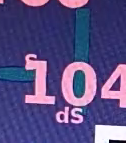

In [7]:
def random_perspective(img):
#     if np.random.randint(3)!=0:
#         pass
#     else:
#         img= np.rot90(img)
    
    
    # only apply to every n_th image
    if np.random.randint(3)!=0:
        return img
    MAX_CHANGE = 0.2
    a = np.random.rand(8).reshape(4,2)
    width, height = img.shape[:2]
    scale_factor = min(width,height)
    a = a*scale_factor*MAX_CHANGE
    pts1 = np.float32([
        [0,0],
        [width,0],
        [width,height],
        [0,height]
    ])
    pts2 = np.float32([
        [0+a[0,0],0+a[0,1]],
        [width-a[1,0],0+a[1,1]],
        [width-a[2,0],height-a[2,1]],
        [0+a[3,0],height-a[3,1]]
    ])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img, M, (height,width))
    
    return img

path = file_list[0]
img = cv2.imread(path)
img = random_perspective(img)

Image.fromarray(img)

## Option 2

In [8]:
im_size = 48
ks = 5

mini_df = df

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.1,
    preprocessing_function = random_perspective
)

y_col = ['l0d','l1d','l2d']
class_mode = 'multi_output'

train_generator = train_datagen.flow_from_dataframe(
    mini_df, directory='/', x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="training", classes=categories,
    batch_size=128, seed=42)

valid_generator = train_datagen.flow_from_dataframe(
    mini_df, directory='/', x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="validation", classes=categories,
    batch_size=128, seed=42)

/home/eduard/.pyenv/versions/3.6.8/envs/keras_gpu_36/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:211: UserWarning: `classes` will be ignored given the class_mode="multi_output"
  .format(self.class_mode))


Found 637204 validated image filenames.
Found 70800 validated image filenames.


### Define model

In [9]:
# kernale size
ks = 5
# number of filters
nf = 32
input_img = Input(shape=(im_size, im_size, 3))
# gs_img = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(input_img)
conv1 = Conv2D(nf, (ks, ks), strides=2, padding='same', activation='relu')(input_img)
drop1 = Dropout(0.05)(conv1)
conv2 = Conv2D(nf, (ks, ks), strides=2, padding='same', activation='relu')(drop1)
drop2 = Dropout(0.05)(conv2)
conv3 = Conv2D(nf, (ks, ks), strides=2, padding='same', activation='relu')(drop2)
flat1  = Flatten()(conv3)
dense1 = Dense(256,activation='relu')(flat1)
num1 = Dense(11,activation='softmax',name='num1')(dense1)
num2 = Dense(11,activation='softmax',name='num2')(dense1)
num3 = Dense(11,activation='softmax',name='num3')(dense1)

# output = keras.layers.concatenate([num1,num2,num3])
# output = [num1,num2,num3]?
model = Model(inputs = input_img, outputs=[num1,num2,num3])
model

W0911 12:54:58.637631 140066032926848 deprecation.py:506] From /home/eduard/.pyenv/versions/3.6.8/envs/keras_gpu_36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 24, 24, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 32)   25632       dropout[0][0]                    
______________________________________________________________________________________________

In [12]:
model_name = 'dragon64_mini_3cl32_dense256'
tensorboard = TensorBoard(log_dir=f'logs/{model_name}')
model_path = 'models/dragon_w_dense'
all_checkpoint_path = f'{model_path}''/ep{epoch:02d}-va{val_loss:.2f}.hdf5'
save_all_callback = ModelCheckpoint(
        all_checkpoint_path, 
        monitor='val_loss',
        save_best_only=False,
    )

In [13]:
model.compile(optimizers.Adam(lr=0.001),loss=["categorical_crossentropy"]*3,metrics=["accuracy"],)

In [14]:
tf.test.is_gpu_available()

False

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=60,
                    callbacks = [tensorboard, save_all_callback]
)

Epoch 1/60
4978/4978 [==============================] - 1791s 360ms/step - loss: 0.3040 - num1_loss: 0.0393 - num2_loss: 0.1277 - num3_loss: 0.1371 - num1_acc: 0.9854 - num2_acc: 0.9598 - num3_acc: 0.9567 - val_loss: 0.2666 - val_num1_loss: 0.0357 - val_num2_loss: 0.1092 - val_num3_loss: 0.1216 - val_num1_acc: 0.9868 - val_num2_acc: 0.9656 - val_num3_acc: 0.9624
Epoch 2/60
4978/4978 [==============================] - 1758s 353ms/step - loss: 0.3057 - num1_loss: 0.0394 - num2_loss: 0.1289 - num3_loss: 0.1375 - num1_acc: 0.9854 - num2_acc: 0.9592 - num3_acc: 0.9564 - val_loss: 0.2941 - val_num1_loss: 0.0406 - val_num2_loss: 0.1217 - val_num3_loss: 0.1318 - val_num1_acc: 0.9849 - val_num2_acc: 0.9626 - val_num3_acc: 0.9595
Epoch 3/60
4978/4978 [==============================] - 1760s 353ms/step - loss: 0.3032 - num1_loss: 0.0395 - num2_loss: 0.1272 - num3_loss: 0.1365 - num1_acc: 0.9854 - num2_acc: 0.9598 - num3_acc: 0.9570 - val_loss: 0.2694 - val_num1_loss: 0.0364 - val_num2_loss: 0.112

In [16]:
! ls

embedded_qr_images_generator.py  python_tflite_benchmarker.py
fonts				 README.md
images				 requirements_qr.txt
images_generator.py		 requirements_training_gpu.txt
KerasOCRTrainer2.py		 take2.avi
KerasOCRTrainer.py		 test.py
logs				 trained_models
logs2				 TrainingDataGenerator2.ipynb
model_converter.py		 TrainingDataGenerator2.py
models				 VideoShredder.py
old_KerasOCRFromBackup.py	 vitmo_3_output_layer_training.ipynb
__pycache__
